In [1]:
# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 2

import os
import sys

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

In [20]:
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
def imshow(x):
    return plt.imshow(x.cpu().numpy().transpose(1,2,0))    

In [65]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.init import xavier_normal
from torchvision import datasets, transforms, utils as vutils
from tensorboardX import SummaryWriter
import numpy as np

In [5]:
use_gpu = torch.cuda.is_available()

In [6]:
dataset = datasets.MNIST('../data', transform=transforms.ToTensor())
dataloader = torch.utils.data.DataLoader(dataset, batch_size=512)

# The simplest possible autoencoder

In [7]:
class Lambda(nn.Module):
    def __init__(self, fn):
        super(Lambda, self).__init__()
        self.fn = fn
    
    def forward(self, x):
        return self.fn(x)

In [86]:
def flatten(x):
    return x.view(x.size(0), -1)

Flatten = Lambda(flatten)

def simple_encoder(encoding_dim=32, input_channels=1, input_size=(28, 28)):    
    in_channels = input_channels * input_size[0] * input_size[1]
    encoder = nn.Sequential(
        Flatten,
        nn.Linear(in_channels, encoding_dim),
        nn.ReLU(True),
    )
    decoder = nn.Sequential(
        nn.Linear(encoding_dim, in_channels),
        nn.Sigmoid(),
        Lambda(lambda x: x.view(x.size(0), input_channels, input_size[0], input_size[1]))
    )
    return encoder, decoder

In [158]:
def sample(model, loader, n=10):
    imgs = next(iter(loader))[0][:n]
    imgs = Variable(imgs)
    if use_gpu:
        imgs = imgs.cuda()

    reconstructions = model(imgs)
    reconstructions = reconstructions.view(reconstructions.size(0), 1, 28, 28)

    return vutils.make_grid(torch.cat([imgs.data, reconstructions.data]), n)

In [10]:
# encoder, decoder = simple_encoder(32)
# autoencoder = nn.Sequential(encoder, decoder)
# optimizer = torch.optim.Adam(autoencoder.parameters(), 3e-4)
# criterion = nn.BCELoss()
# if use_gpu:
#     encoder.cuda()
#     decoder.cuda()
#     criterion.cuda()
    
# for e in range(50):
#     epoch_loss = []
#     for batch, (inputs, _) in enumerate(dataloader):
#         inputs = inputs#.squeeze(1).view(inputs.size(0), -1)
#         inputs = Variable(inputs)
#         if use_gpu:
#             inputs = inputs.cuda()
            
#         optimizer.zero_grad()
        
#         output = decoder(encoder(inputs))
#         loss = criterion(output, inputs)
        
#         loss.backward()
#         optimizer.step()

#         l = loss.data[0]
#         epoch_loss.append(l)
    
#     avg_epoch_loss = np.mean(epoch_loss)
#     print(e, avg_epoch_loss)
#     writer.add_scalar('simple/loss', avg_epoch_loss, e)
#     writer.add_image('Simple', sample(autoencoder, dataloader), e)

In [22]:
import torchnet as tnt
from torchnet.engine import Engine

writer = SummaryWriter('runs/simple_{}'.format(datetime.now().strftime('%b%d_%H-%M-%S')))
engine = Engine()
meter_loss = tnt.meter.AverageValueMeter()

encoder, decoder = simple_encoder(32)
autoencoder = nn.Sequential(encoder, decoder)
optimizer = torch.optim.Adam(autoencoder.parameters(), 3e-4)
criterion = nn.BCELoss()
if use_gpu:
    encoder.cuda()
    decoder.cuda()
    criterion.cuda()

def h(sample):
    inputs, _ = sample

    inputs = Variable(inputs)
    if use_gpu:
        inputs = inputs.cuda()

    output = decoder(encoder(inputs))
    loss = criterion(output, inputs)
    
    return loss, output

def on_sample(state):
    print('on sample')
#     print(state['train'])
    
def on_forward(state):
    meter_loss.add(state['loss'].data[0])
    
def on_end_epoch(state):
    writer.add_scalar('loss', meter_loss.value()[0], state['epoch'])
    writer.add_image('image', sample(autoencoder, dataloader), state['epoch'])
    
    meter_loss.reset()

# engine.hooks['on_sample'] = on_sample
engine.hooks['on_forward'] = on_forward
engine.hooks['on_end_epoch'] = on_end_epoch
engine.train(h, dataloader, maxepoch=50, optimizer=optimizer)

{'epoch': 50,
 'iterator': <torch.utils.data.dataloader.DataLoader at 0x7f2c8a93e4e0>,
 'loss': None,
 'maxepoch': 50,
 'network': <function __main__.h>,
 'optimizer': <torch.optim.adam.Adam at 0x7f2c7c456278>,
 'output': None,
 'sample': [
  (0 ,0 ,.,.) = 
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
             ...             ⋱             ...          
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
       ⋮ 
  
  (1 ,0 ,.,.) = 
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
             ...             ⋱             ...          
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
    0.0000  0.0000  0.0000  

## Deep Autoencoder

In [29]:
flatten = Lambda(lambda x: x.view(x.size(0), -1))

class DeepAutoencoder(nn.Module):
    def __init__(self, encoding_dims=[128, 64, 32], input_channels=1, input_size=(28, 28)):
        super(DeepAutoencoder, self).__init__()

        in_channels = input_channels * input_size[0] * input_size[1]
        
        encoder_blocks = []
        in_size = in_channels
        for output_size in encoding_dims:
            encoder_blocks.append(nn.Linear(in_size, output_size))
            encoder_blocks.append(nn.ReLU(True))
            in_size = output_size
        
        self.encoder = nn.Sequential(
            flatten,
            *encoder_blocks
        )
        
        decoder_blocks = []
        in_size = encoding_dims[-1]
        for output_size in encoding_dims[1::-1]:
            decoder_blocks.append(nn.Linear(in_size, output_size))
            decoder_blocks.append(nn.ReLU(True))
            in_size = output_size

        decoder_blocks.append(nn.Linear(in_size, in_channels))
        decoder_blocks.append(nn.Sigmoid())
        self.decoder = nn.Sequential(
            *decoder_blocks,
            Lambda(lambda x: x.view(x.size(0), input_channels, input_size[0], input_size[1]))
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [31]:
import torchnet as tnt
from torchnet.engine import Engine

writer = SummaryWriter('runs/deep_{}'.format(datetime.now().strftime('%b%d_%H-%M-%S')))
engine = Engine()
meter_loss = tnt.meter.AverageValueMeter()

model = DeepAutoencoder()
optimizer = torch.optim.Adam(model.parameters(), 3e-4)
criterion = nn.BCELoss()
if use_gpu:
    model.cuda()
    criterion.cuda()

def h(sample):
    inputs, _ = sample

    inputs = Variable(inputs)
    if use_gpu:
        inputs = inputs.cuda()

    output = model(inputs)
    loss = criterion(output, inputs)
    
    return loss, output

def on_sample(state):
    print('on sample')
#     print(state['train'])
    
def on_forward(state):
    meter_loss.add(state['loss'].data[0])
    
def on_start_epoch(state):
    meter_loss.reset()

def on_end_epoch(state):
    writer.add_scalar('loss', meter_loss.value()[0], state['epoch'])
    writer.add_image('image', sample(model, dataloader), state['epoch'])
    
    meter_loss.reset()

# engine.hooks['on_sample'] = on_sample
engine.hooks['on_forward'] = on_forward
engine.hooks['on_start_epoch'] = on_start_epoch
engine.hooks['on_end_epoch'] = on_end_epoch
engine.train(h, dataloader, maxepoch=100, optimizer=optimizer)

{'epoch': 100,
 'iterator': <torch.utils.data.dataloader.DataLoader at 0x7f2c8a93e4e0>,
 'loss': None,
 'maxepoch': 100,
 'network': <function __main__.h>,
 'optimizer': <torch.optim.adam.Adam at 0x7f2c7c461438>,
 'output': None,
 'sample': [
  (0 ,0 ,.,.) = 
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
             ...             ⋱             ...          
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
       ⋮ 
  
  (1 ,0 ,.,.) = 
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
             ...             ⋱             ...          
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
    0.0000  0.0000  0.0000

## Convolutional Autoencoder

In [78]:
class ConvolutionalAutoencoder(nn.Module):
    def __init__(self, in_channels=1, init_weights=True):
        super(ConvolutionalAutoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 16, (3, 3), padding=1),
            nn.ReLU(True),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(16, 8, (3, 3), padding=1),
            nn.ReLU(True),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(8, 8, (3, 3), padding=1),
            nn.ReLU(True),
            nn.MaxPool2d((2, 2), padding=1),
        )
        
        self.decoder = nn.Sequential(
            nn.Conv2d(8, 8, (3, 3), padding=1),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(8, 8, (3, 3), padding=1),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(8, 16, (3, 3), padding=0),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(16, in_channels, kernel_size=(3, 3), padding=1),
            nn.Sigmoid(),
        )
        
        if init_weights:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    xavier_normal(m.weight.data)

    def forward(self, x):
        return self.decoder(self.encoder(x))
    
# model = ConvolutionalAutoencoder()
# model(Variable(next(iter(dataloader))[0])).size()[1:]

In [80]:
import torchnet as tnt
from torchnet.engine import Engine

writer = SummaryWriter('runs/conv_initialized_adadelta{}'.format(datetime.now().strftime('%b%d_%H-%M-%S')))
engine = Engine()
meter_loss = tnt.meter.AverageValueMeter()

model = ConvolutionalAutoencoder()
# optimizer = torch.optim.Adam(model.parameters(), 3e-4)
optimizer = torch.optim.Adadelta(model.parameters())
criterion = nn.BCELoss()
if use_gpu:
    model.cuda()
    criterion.cuda()

def h(sample):
    inputs, _ = sample

    inputs = Variable(inputs)
    if use_gpu:
        inputs = inputs.cuda()

    output = model(inputs)
    loss = criterion(output, inputs)
    
    return loss, output

def on_sample(state):
    print('on sample')
#     print(state['train'])
    
def on_forward(state):
    meter_loss.add(state['loss'].data[0])
    
def on_start_epoch(state):
    meter_loss.reset()

def on_end_epoch(state):
    writer.add_scalar('loss', meter_loss.value()[0], state['epoch'])
    writer.add_image('image', sample(model, dataloader), state['epoch'])
    
    meter_loss.reset()

# engine.hooks['on_sample'] = on_sample
engine.hooks['on_forward'] = on_forward
engine.hooks['on_start_epoch'] = on_start_epoch
engine.hooks['on_end_epoch'] = on_end_epoch
engine.train(h, dataloader, maxepoch=100, optimizer=optimizer)

{'epoch': 100,
 'iterator': <torch.utils.data.dataloader.DataLoader at 0x7f2c8a93e4e0>,
 'loss': None,
 'maxepoch': 100,
 'network': <function __main__.h>,
 'optimizer': <torch.optim.adadelta.Adadelta at 0x7f2c3cb20550>,
 'output': None,
 'sample': [
  (0 ,0 ,.,.) = 
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
             ...             ⋱             ...          
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
       ⋮ 
  
  (1 ,0 ,.,.) = 
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
             ...             ⋱             ...          
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
    0.0000  0.0000

## Variational Autoencoders

In [154]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, in_channels=1, input_size=(28, 28), hidden_dim=400, latent_dim=2):
        super(VariationalAutoencoder, self).__init__()
        
        self.sz = in_channels * input_size[0] * input_size[1]
        self.in_channels = in_channels
        self.input_size = input_size
        
        self.fc1 = nn.Linear(self.sz, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, self.sz)
        
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)
    
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h3))
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
        
        
    def forward(self, x):
        mu, logvar = self.encode(flatten(x))
        z = self.reparameterize(mu, logvar)
        decoded = self.decode(z)

#         return decoded.view(decoded.size(0), self.in_channels, *self.input_size), mu, logvar
        return decoded, mu, logvar

#VariationalAutoencoder(latent_dim=20)(Variable(torch.Tensor(1, 1, 28, 28)))

In [165]:
def vae_loss(output, target, mu, logvar):
    recon_loss = F.binary_cross_entropy(output, target.view(-1, 784), size_average=False)
    
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl_loss = 0.5 * torch.sum(torch.exp(logvar) + mu**2 - 1. - logvar)
#     KLD / 512 * 784
    return recon_loss + kl_loss

In [166]:
def sample_vae(model, loader, n=10):
    model.eval()
    imgs = next(iter(loader))[0][:n]
    imgs = Variable(imgs)
    if use_gpu:
        imgs = imgs.cuda()

    reconstructions, _, _ = model(imgs)
    reconstructions = reconstructions.view(reconstructions.size(0), 1, 28, 28)

    return vutils.make_grid(torch.cat([imgs.data, reconstructions.data]), n)

In [190]:
import torchnet as tnt
from torchnet.engine import Engine

writer = SummaryWriter('runs/vae_ld2_adadelta{}'.format(datetime.now().strftime('%b%d_%H-%M-%S')))
engine = Engine()
meter_loss = tnt.meter.AverageValueMeter()

model = VariationalAutoencoder(latent_dim=2)
# optimizer = torch.optim.Adam(model.parameters(), 3e-4)
optimizer = torch.optim.Adadelta(model.parameters())
criterion = vae_loss
if use_gpu:
    model.cuda()
#     criterion.cuda()

def h(sample):
    inputs, _ = sample

    inputs = Variable(inputs)
    if use_gpu:
        inputs = inputs.cuda()

    output, mu, logvar = model(inputs)
    loss = criterion(output, inputs, mu, logvar)
    
    return loss, output

def on_sample(state):
    print('on sample')
#     print(state['train'])
    
def on_forward(state):
    meter_loss.add(state['loss'].data[0])
    
def on_start_epoch(state):
    meter_loss.reset()

def on_end_epoch(state):
    writer.add_scalar('loss', meter_loss.value()[0], state['epoch'])
    writer.add_image('image', sample_vae(model, dataloader), state['epoch'])
    meter_loss.reset()

# engine.hooks['on_sample'] = on_sample
engine.hooks['on_forward'] = on_forward
engine.hooks['on_start_epoch'] = on_start_epoch
engine.hooks['on_end_epoch'] = on_end_epoch
engine.train(h, dataloader, maxepoch=100, optimizer=optimizer)

{'epoch': 100,
 'iterator': <torch.utils.data.dataloader.DataLoader at 0x7f2c8a93e4e0>,
 'loss': None,
 'maxepoch': 100,
 'network': <function __main__.h>,
 'optimizer': <torch.optim.adadelta.Adadelta at 0x7f2c1c588278>,
 'output': None,
 'sample': [
  (0 ,0 ,.,.) = 
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
             ...             ⋱             ...          
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
       ⋮ 
  
  (1 ,0 ,.,.) = 
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
             ...             ⋱             ...          
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
    0.0000  0.0000

In [179]:
imgs, labels = next(iter(dataloader))
encoded, _ = model.encode(Variable(imgs).cuda().view(-1, 784))
from sklearn.manifold import TSNE

pts = TSNE(n_components=2).fit_transform(encoded.data.cpu().numpy())

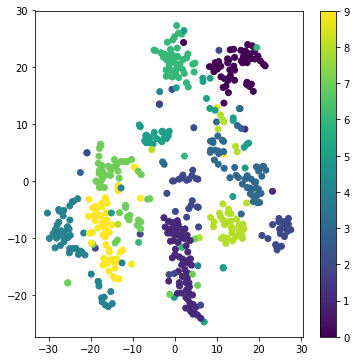

In [188]:
plt.figure(figsize=(6, 6))
plt.scatter(pts[:, 0], pts[:, 1], c=labels.numpy())
plt.colorbar()
plt.show()

In [209]:
class ConvVariationalAutoencoder(nn.Module):
    def __init__(self, in_channels=1, input_size=(28, 28), hidden_dim=400, latent_dim=2):
        super(ConvVariationalAutoencoder, self).__init__()
        
        self.sz = in_channels * input_size[0] * input_size[1]
        self.in_channels = in_channels
        self.input_size = input_size
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 16, (3, 3), padding=1),
            nn.ReLU(True),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(16, 8, (3, 3), padding=1),
            nn.ReLU(True),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(8, 8, (3, 3), padding=1),
            nn.ReLU(True),
            nn.MaxPool2d((2, 2), padding=1),
        )
        
        self.decoder = nn.Sequential(
            nn.Conv2d(8, 8, (3, 3), padding=1),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(8, 8, (3, 3), padding=1),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(8, 16, (3, 3), padding=0),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(16, in_channels, kernel_size=(3, 3), padding=1),
            nn.Sigmoid(),
        )


        self.fc21 = nn.Linear(128, latent_dim)
        self.fc22 = nn.Linear(128, latent_dim)
        
        self.fc3 = nn.Linear(latent_dim, 128)
            
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                xavier_normal(m.weight.data)

        
    def encode(self, x):
        h1 = flatten(self.encoder(x))
        return self.fc21(h1), self.fc22(h1)
    
    def decode(self, z):
        h2 = self.fc3(z).view(z.size(0), 8, 4, 4)
        return self.decoder(h2)
#         h3 = F.relu(self.fc3(z))
#         return F.sigmoid(self.fc4(h3))
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        decoded = self.decode(z)

        return decoded, mu, logvar

ConvVariationalAutoencoder(latent_dim=20)(Variable(torch.Tensor(1, 1, 28, 28)))

(Variable containing:
 (0 ,0 ,.,.) = 
 
 Columns 0 to 18 
   nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan

In [210]:
import torchnet as tnt
from torchnet.engine import Engine

writer = SummaryWriter('runs/conv_vae_ld20_adadelta{}'.format(datetime.now().strftime('%b%d_%H-%M-%S')))
engine = Engine()
meter_loss = tnt.meter.AverageValueMeter()

model = ConvVariationalAutoencoder(latent_dim=20)
# optimizer = torch.optim.Adam(model.parameters(), 3e-4)
optimizer = torch.optim.Adadelta(model.parameters())
criterion = vae_loss
if use_gpu:
    model.cuda()
#     criterion.cuda()

def h(sample):
    inputs, _ = sample

    inputs = Variable(inputs)
    if use_gpu:
        inputs = inputs.cuda()

    output, mu, logvar = model(inputs)
    loss = criterion(output, inputs, mu, logvar)
    
    return loss, output

def on_sample(state):
    print('on sample')
#     print(state['train'])
    
def on_forward(state):
    meter_loss.add(state['loss'].data[0])
    
def on_start_epoch(state):
    meter_loss.reset()

def on_end_epoch(state):
    writer.add_scalar('loss', meter_loss.value()[0], state['epoch'])
    writer.add_image('image', sample_vae(model, dataloader), state['epoch'])
    meter_loss.reset()

# engine.hooks['on_sample'] = on_sample
engine.hooks['on_forward'] = on_forward
engine.hooks['on_start_epoch'] = on_start_epoch
engine.hooks['on_end_epoch'] = on_end_epoch
engine.train(h, dataloader, maxepoch=100, optimizer=optimizer)

/home/jon/anaconda3/envs/torch/lib/python3.5/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([512, 784])) that is different to the input size (torch.Size([512, 1, 28, 28])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/home/jon/anaconda3/envs/torch/lib/python3.5/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([96, 784])) that is different to the input size (torch.Size([96, 1, 28, 28])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


{'epoch': 100,
 'iterator': <torch.utils.data.dataloader.DataLoader at 0x7f2c8a93e4e0>,
 'loss': None,
 'maxepoch': 100,
 'network': <function __main__.h>,
 'optimizer': <torch.optim.adadelta.Adadelta at 0x7f2bf0d1b128>,
 'output': None,
 'sample': [
  (0 ,0 ,.,.) = 
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
             ...             ⋱             ...          
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
       ⋮ 
  
  (1 ,0 ,.,.) = 
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
             ...             ⋱             ...          
    0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
    0.0000  0.0000

In [220]:
# https://github.com/ptrblck/prog_gans_pytorch_inference/blob/master/utils.py
def slerp(val, low, high):
    '''
    original: Animating Rotation with Quaternion Curves, Ken Shoemake
    
    https://arxiv.org/abs/1609.04468
    Code: https://github.com/soumith/dcgan.torch/issues/14, Tom White
    '''
    omega = np.arccos(np.dot(low/np.linalg.norm(low), high/np.linalg.norm(high)))
    so = np.sin(omega)
    return np.sin((1.0-val)*omega) / so * low + np.sin(val*omega)/so * high


def get_slerp_interp(nb_latents, nb_interp):
    low = np.random.randn(128)
    
    latent_interps = np.empty(shape=(0, 128), dtype=np.float32)
    for _ in range(nb_latents):
        high = np.random.randn(128)#low + np.random.randn(512) * 0.7
        
        interp_vals = np.linspace(1./nb_interp, 1, num=nb_interp)
        latent_interp = np.array([slerp(v, low, high) for v in interp_vals],
                                  dtype=np.float32)
        
        latent_interps = np.vstack((latent_interps, latent_interp))
        low = high

    return latent_interps[:, :, np.newaxis, np.newaxis]

class LatentDataset(Dataset):
    def __init__(self, interp_type='gauss', nb_latents=1, filter_latents=3,
                 nb_interp=50):
        if interp_type=='gauss':
            latents = get_gaussian_latents(nb_latents, filter_latents)
        elif interp_type=='slerp':
            latents = get_slerp_interp(nb_latents, nb_interp)
        self.data = torch.from_numpy(latents)

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
return len(self.data)

IndentationError: expected an indented block (<ipython-input-220-6b23fdecade5>, line 43)

In [219]:
torch.from_numpy(get_slerp_interp(1,50))


( 0 , 0 ,.,.) = 
 -0.2529

( 0 , 1 ,.,.) = 
 -0.9223

( 0 , 2 ,.,.) = 
 -0.3728
    ... 

( 0 ,125,.,.) = 
 -0.3113

( 0 ,126,.,.) = 
 -0.4204

( 0 ,127,.,.) = 
 -0.4730
      ⋮  

( 1 , 0 ,.,.) = 
 -0.1992

( 1 , 1 ,.,.) = 
 -0.8980

( 1 , 2 ,.,.) = 
 -0.4177
    ... 

( 1 ,125,.,.) = 
 -0.3654

( 1 ,126,.,.) = 
 -0.4699

( 1 ,127,.,.) = 
 -0.4700
      ⋮  

( 2 , 0 ,.,.) = 
 -0.1454

( 2 , 1 ,.,.) = 
 -0.8730

( 2 , 2 ,.,.) = 
 -0.4623
    ... 

( 2 ,125,.,.) = 
 -0.4192

( 2 ,126,.,.) = 
 -0.5189

( 2 ,127,.,.) = 
 -0.4666
...     
      ⋮  

(47 , 0 ,.,.) = 
  1.7236

(47 , 1 ,.,.) = 
  0.6351

(47 , 2 ,.,.) = 
 -1.5500
    ... 

(47 ,125,.,.) = 
 -1.8402

(47 ,126,.,.) = 
 -1.7069

(47 ,127,.,.) = 
  0.0152
      ⋮  

(48 , 0 ,.,.) = 
  1.7391

(48 , 1 ,.,.) = 
  0.6660

(48 , 2 ,.,.) = 
 -1.5458
    ... 

(48 ,125,.,.) = 
 -1.8391

(48 ,126,.,.) = 
 -1.7019

(48 ,127,.,.) = 
  0.0296
      ⋮  

(49 , 0 ,.,.) = 
  1.7530

(49 , 1 ,.,.) = 
  0.6962

(49 , 2 ,.,.) = 
 -1.5401
    .